# Goal

Develop a model for Rusty Bargain used car sales service to determine the market value of a car based on historical data (technical specifications, trim versions, and prices).

## Key metrics

the quality of the prediction
the speed of the prediction
the time required for training
Data description

## Features

    - DateCrawled — date profile was downloaded from the database
    - VehicleType — vehicle body type
    - RegistrationYear — vehicle registration year
    - Gearbox — gearbox type
    - Power — power (hp)
    - Model — vehicle model
    - Mileage — mileage (measured in km due to dataset's regional specifics)
    - RegistrationMonth — vehicle registration month
    - FuelType — fuel type
    - Brand — vehicle brand
    - NotRepaired — vehicle repaired or not
    - DateCreated — date of profile creation
    - NumberOfPictures — number of vehicle pictures
    - PostalCode — postal code of profile owner (user)
    - LastSeen — date of the last activity of the user

## Target

Price — price (Euro)

# Imports

In [149]:
import pandas as pd
import matplotlib
import numpy as np
from numpy import *
import re
import time
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor as LGB
from xgboost import XGBRegressor
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from fancyimpute import KNN
import tensorflow as tf
from sklearn.impute import KNNImputer as knni
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, Normalizer
from sklearn.metrics import mean_squared_error

import pickle
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None, 'display.max_columns', None)

print("Setup Complete")

Setup Complete


<div class="alert alert-block alert-success">
<b>Success:</b> Thank you for collecting all imports in the first cell!
</div>

## Input data

In [80]:
try:
    df = pd.read_csv('car_data.csv')
    
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [81]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


# Preprocessing

## Clean variable names

In [82]:
columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)

In [83]:
df.columns = columns

In [84]:
df.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


## Check and Drop Duplicates on Original DF

In [85]:
df.duplicated().sum()

262

In [86]:
df.drop_duplicates(inplace=True)

In [87]:
df.shape

(354107, 16)

## Change Date Type

In [88]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen']    = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

### Create days on site variable

In [89]:
df['days_on_site'] = (df['last_seen'] - df['date_created']).dt.days

###  Clean registration_year and Create car age variable

In [90]:
df.registration_year.value_counts().sort_index().head(10)

1000    37
1001     1
1039     1
1111     3
1200     1
1234     4
1253     1
1255     1
1300     2
1400     1
Name: registration_year, dtype: int64

In [91]:
df.registration_year.value_counts().sort_index(ascending= False).head(25)

9999    26
9996     1
9450     1
9229     1
9000     3
8888     1
8500     1
8455     1
8200     1
8000     2
7800     1
7500     1
7100     1
7000     4
6500     1
6000     5
5911     2
5900     1
5600     1
5555     2
5300     1
5000    17
4800     1
4500     2
4100     1
Name: registration_year, dtype: int64

In [92]:
df = df[(df[['registration_year']] > 1909).any(axis=1)& (df[['registration_year']] < 2020).any(axis=1)]

In [93]:
df['car_age'] = 2019 - df['registration_year']

In [94]:
df['car_age'].describe()

count    353936.000000
mean         15.915154
std           7.537331
min           0.000000
25%          11.000000
50%          16.000000
75%          20.000000
max         109.000000
Name: car_age, dtype: float64

## Drop useless and redundant variables

Some variable do not add any information like date crawled.  Other variables are related to one another like brand and mode.  Some variables are empty like number of pictures.  Registration would be important if it were the first time the car was registered, but no such info is available, so it could only be noise.

In [95]:
drop_cols = ["date_crawled", "registration_year", "not_repaired", "registration_month", "date_created", "last_seen",  "number_of_pictures", "brand"]
df.drop(drop_cols, axis=1, inplace=True)

In [96]:
df.head()

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,postal_code,days_on_site,car_age
0,480,NaN,manual,0,golf,150000,petrol,70435,14,26
1,18300,coupe,manual,190,NaN,125000,gasoline,66954,14,8
2,9800,suv,auto,163,grand,125000,gasoline,90480,22,15
3,1500,small,manual,75,golf,150000,petrol,91074,0,18
4,3600,small,manual,69,fabia,90000,gasoline,60437,6,11


## Cleaning the target

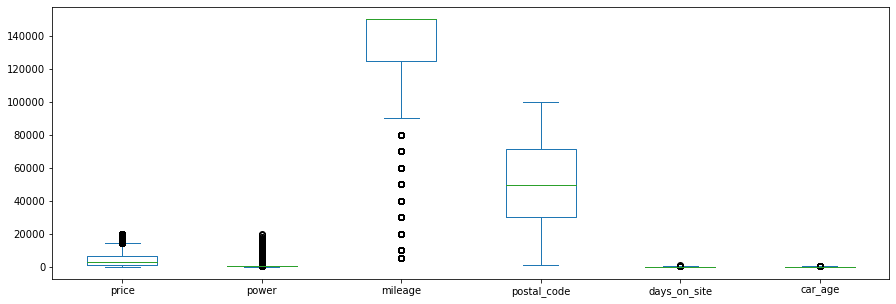

In [97]:
df.plot(kind='box', figsize=(15, 5));

### Which lower cutoff should be used as a car price?

In [98]:
df.price.value_counts().sort_index().head(35)

0     10738
1      1180
2        12
3         8
4         1
5        26
7         3
8         9
9         8
10       84
11        5
12        8
13        7
14        5
15       27
16        2
17        5
18        3
19        3
20       50
21        1
24        1
25       32
26        1
27        1
29        2
30       54
32        1
33        1
35       18
38        1
39        6
40       45
45       16
47        1
Name: price, dtype: int64

In [99]:
df = df[(df[['price']] > 50).any(axis=1)]

In [100]:
df.shape

(341236, 10)

### Conclusion:
We lost quite a few rows, around 4000.

## Cleaning Power

In [101]:
df = df[(df.power < 2000) & (df.power != 0)]

In [102]:
df.shape

(305858, 10)

### Conclusion:
We lost a lot of data by cleaning both price and power, but that was necessary to make our data useful.

## Missing Values

In [103]:
# missing values
df.isnull().mean().sort_values(ascending=False) *100

vehicle_type    6.902876
fuel_type       6.397740
model           4.039456
gearbox         1.959079
price           0.000000
power           0.000000
mileage         0.000000
postal_code     0.000000
days_on_site    0.000000
car_age         0.000000
dtype: float64

### Conclusion:
vehicle_type, fuel_type, gearbox, model.  Our target, price, does not have missing values.            

In [104]:
def category_distribution(df, field):
    """
    Distribution of categorical features
    """
    print(f'Distribution for {field}')
    print(df[field].value_counts(normalize=True, dropna=False)*100)
    print()

In [105]:
cat_cols = [ 'vehicle_type', 'fuel_type', 'gearbox', 'model']
for col in cat_cols:
    category_distribution(df, col)

Distribution for vehicle_type
sedan          27.103100
small          22.833145
wagon          19.330866
bus             8.554950
NaN             6.902876
convertible     6.124738
coupe           4.759398
suv             3.577804
other           0.813122
Name: vehicle_type, dtype: float64

Distribution for fuel_type
petrol      62.538171
gasoline    29.215518
NaN          6.397740
lpg          1.564125
cng          0.162494
hybrid       0.066698
other        0.030406
electric     0.024848
Name: fuel_type, dtype: float64

Distribution for gearbox
manual    78.354007
auto      19.686914
NaN        1.959079
Name: gearbox, dtype: float64

Distribution for model
golf                  8.474848
other                 6.775366
3er                   5.789942
NaN                   4.039456
polo                  3.627827
corsa                 3.429696
astra                 3.077899
passat                2.936330
a4                    2.920309
c_klasse              2.436425
5er                   2.

https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa

## Encode Categorical variables

Since data is nominal and not ordinal, I will use the OneHotEncoder. https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/ and
https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

### Dummy Encoding

In [106]:
df_cat = df.copy()
df_cat = df.select_dtypes(include=['object'])
df_enc = df_cat.copy()

df_enc = pd.get_dummies(df_enc, columns=['vehicle_type', 'fuel_type', 'gearbox', 'model'])

df_dum = df.drop(['vehicle_type', 'fuel_type', 'gearbox', 'model'],axis=1)

df_dum = pd.concat([df_dum,df_enc], axis=1)

In [107]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305858 entries, 1 to 354368
Columns: 272 entries, price to model_zafira
dtypes: int64(6), uint8(266)
memory usage: 93.9 MB


### Ordinal Encoding

In [108]:
oe = OrdinalEncoder()
#create a list of categorical columns to iterate over
nan_cols = [ 'vehicle_type', 'fuel_type', 'gearbox', 'model']

Encode categorical variables without encoding the NANs

In [111]:
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    knn_reshape = nonulls.reshape(-1,1)
    #encode date
    knn_ordinal = oe.fit_transform(knn_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(knn_ordinal)
    return len(data), data.isnull().sum()

In [112]:
#create a for loop to iterate through each column in the data
for columns in nan_cols:
    encode(df[columns])

### Use KNN to fill nas

In [113]:
knn = knni()
#df_oe = pd.DataFrame(np.round(knn.fit_transform(df)),columns = df.columns)
#df_dum = pd.DataFrame(np.round(knn.fit_transform(df_dum)),columns = df_dum.columns)

In [114]:
#joblib.dump(df_oe, 'df_oe.pkl')

['df_oe.pkl']

In [115]:
#joblib.dump(df_dum, 'df_dum.pkl')

['df_dum.pkl']

In [116]:
df_oe = joblib.load('oe_data.pkl')

In [117]:
df_dum = joblib.load('df_dum.pkl')

### More duplicates after filling NA?

In [118]:
df_oe.duplicated().sum()

10622

In [119]:
df_oe.drop_duplicates(inplace=True)

In [120]:
df_oe.shape

(295236, 10)

In [121]:
df_dum.duplicated().sum()

10356

In [122]:
df_dum.drop_duplicates(inplace=True)

In [123]:
df_dum.shape

(295502, 272)

### Check for Multicollinearity to determine missingness patterns

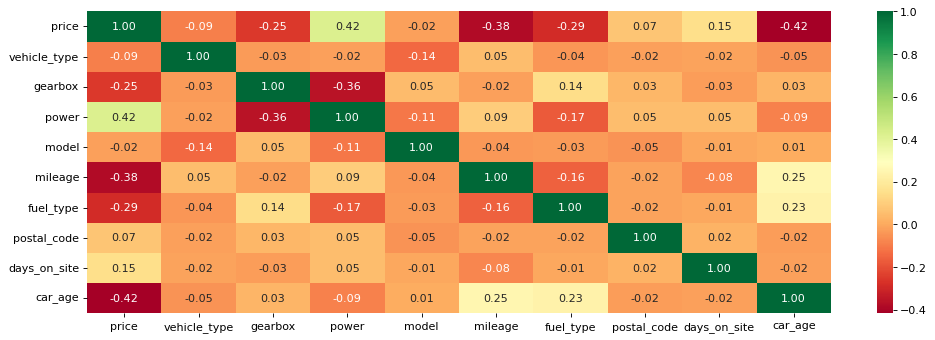

In [124]:
plt.figure(figsize=(15, 5), dpi=80)
sns.heatmap(df_oe.corr(), annot=True, cmap="RdYlGn", fmt=".2f")
plt.show()

#### Conclusion:
There is medium correlation between the target and engine power, gearbox, fuel type, car age and mileage.  There is also a mild negative relationship between power and gearbox.

### VIF
shows the correlation of a feature with the rest of the features.

In [125]:
def calc_vif(X):
# Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [126]:
XXX = df_oe.drop(['price'],axis=1)
calc_vif(XXX)

,variables,VIF
0,vehicle_type,4.746914
1,gearbox,5.170669
2,power,4.558466
3,model,3.146815
4,mileage,11.858580
5,fuel_type,7.239515
6,postal_code,4.615916
7,days_on_site,2.040353
8,car_age,7.027662


#### Conclusion:
A VIF of above 10 could be problematic

In [127]:
XXX = df_oe.drop(['mileage'],axis=1)
calc_vif(XXX)

,variables,VIF
0,price,2.996324
1,vehicle_type,4.380039
2,gearbox,4.854068
3,power,5.504031
4,model,3.134877
5,fuel_type,7.241702
6,postal_code,4.656028
7,days_on_site,2.121934
8,car_age,6.405004


#### Conclusion:
Mileage may or may not be causing us problems.  We will try to model with it and without it to have a better answer

## Check for Outliers

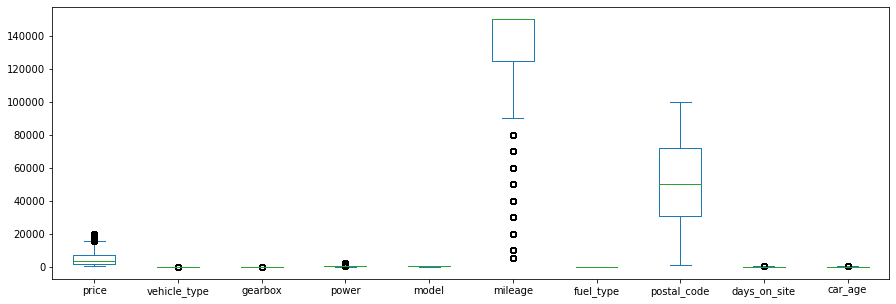

In [128]:
df_oe.plot(kind='box', figsize=(15, 5));

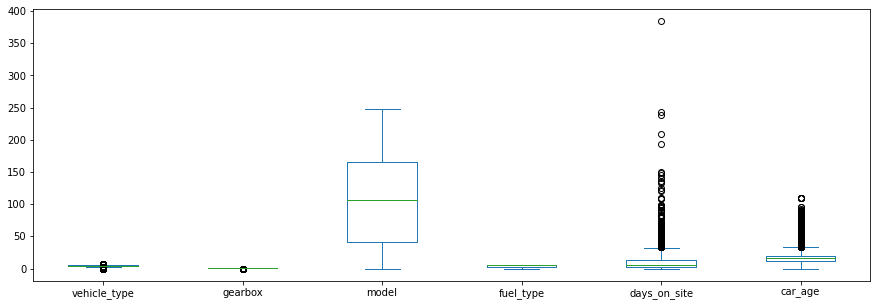

In [129]:
df_oe.drop(['postal_code',  'price', 'mileage', 'power'], axis=1).plot(kind='box', figsize=(15, 5));

### Conclusion:
Though power seems like it has outliers, in fact, this is important data that represents those powerful cars with bigger engines that are rare in real life.  Days on site also seems like it has outliers, but those help us predict it cars that stay longer cost less.  Mileage also see to have outliers, but those are the newer cars that have very few miles on them and help us predict newer and more expensive cars.  In a nutshell, we do not need to drop outliers.  But we will take care of them when we scale the data.

In [ ]:
# pct lost
1 - [df_oe.shape[0]/df_org.shape[0]]*100

In [ ]:
# pct lost
1 - [df_dum.shape[0]/df_org.shape[0]]*100

### Conclusion of Preprocessing:
We lost around 15% of our dataset.  That is huge, but it was needed.  Variables like "date_crawled", "registration_year", "not_repaired", "registration_month", "date_created", "last_seen", "number_of_pictures" are useless and only add noise.  

    
    - date_crawled is irrelevant to price.
    
    - not_repaired is unbalanced and does not say anything about the type of repair.
    
    - date create and date seen were combined to create a date on site, which summaries this information into a single variable.
    
    - number of pix is empty
    
    - Cars that cost less than 50 dollars add more noise than signal
    
    - Cars that have a HP above 2000 add more noise than signal

## Modelling

### Split the oe data

In [132]:
train_X_oe, test_X_oe, train_y_oe, test_y_oe = train_test_split(df_oe.drop(['price'], axis=1),
                                                      df_oe['price'], test_size=0.2, random_state=42)

#### Split the test data

In [133]:
valid_X_oe, test_X_oe, valid_y_oe, test_y_oe = train_test_split(test_X_oe,
                                                      test_y_oe, test_size=0.1, random_state=42)

In [134]:
train_X_oe.shape, valid_X_oe.shape, test_X_oe.shape, train_y_oe.shape, valid_y_oe.shape, test_y_oe.shape

((236188, 9), (53143, 9), (5905, 9), (236188,), (53143,), (5905,))

### Split the dum data

In [135]:
train_X_dum, test_X_dum, train_y_dum, test_y_dum = train_test_split(df_dum.drop(['price'], axis=1),
                                                      df_dum['price'], test_size=0.2, random_state=42)

#### Split the test data

In [136]:
valid_X_dum, test_X_dum, valid_y_dum, test_y_dum = train_test_split(test_X_dum,
                                                      test_y_dum, test_size=0.1, random_state=42)

In [137]:
train_X_dum.shape, valid_X_dum.shape, test_X_dum.shape, train_y_dum.shape, valid_y_dum.shape, test_y_dum.shape

((236401, 271), (53190, 271), (5911, 271), (236401,), (53190,), (5911,))

### Standardization to improve modelling performance

QuantileTransformer, PowerTransformer to account for outliers

In [138]:
qt = QuantileTransformer()
train_X_oe = qt.fit_transform(train_X_oe)
valid_X_oe = qt.transform(valid_X_oe)
test_X_oe = qt.transform(test_X_oe)
train_X_dum = qt.fit_transform(train_X_dum)
valid_X_dum = qt.transform(valid_X_dum)
test_X_dum = qt.transform(test_X_dum)

### Scorer

In [139]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

### GridSearch

In [140]:
def build_model(model, train_X, train_y, valid_X, valid_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(valid_X)
    best_rmse = rmse(valid_y, preds)
    end_time = time.time() - start_time
    print(gs.best_estimator_)
    print(best_rmse)
    print(np.round(end_time, 2))

    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [141]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X_oe, train_y_oe, 
                                                        valid_X_oe, valid_y_oe,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=5)

LinearRegression()
2949.730102641733
0.59


In [142]:
lr = LinearRegression()
best_lr_model_dum, best_lr_rmse_dum, best_lr_time_dum = build_model(lr, train_X_dum, train_y_dum, 
                                                        valid_X_dum, valid_y_dum,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=5)

LinearRegression()
2499.869036956648
27.78


In [143]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X_oe, train_y_oe, 
                                                        valid_X_oe, valid_y_oe,
                                                        hyperparameters={'n_estimators': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse), cv=5)

RandomForestRegressor(n_estimators=20, random_state=42)
1724.9540973836617
537.11


In [144]:
rf = RandomForestRegressor(random_state=42)
best_rf_model_dum, best_rf_rmse_dum, best_rf_time_dum = build_model(rf, train_X_dum, train_y_dum, 
                                                        valid_X_dum, valid_y_dum,
                                                        hyperparameters={'n_estimators': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse), cv=5)

RandomForestRegressor(n_estimators=20, random_state=42)
1684.56462411372
4726.89


In [145]:
cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X_oe, train_y_oe, 
                                                        valid_X_oe, valid_y_oe,
                                                        hyperparameters={'iterations': [20, 30, 40, 50], 'depth': [5,10]}, 
                scoring=make_scorer(rmse), cv=5, model_str='catboost')

0:	learn: 2860.1317519	total: 102ms	remaining: 1.94s
1:	learn: 2540.1604339	total: 126ms	remaining: 1.14s
2:	learn: 2396.4206154	total: 148ms	remaining: 838ms
3:	learn: 2313.0044924	total: 166ms	remaining: 663ms
4:	learn: 2269.1977714	total: 190ms	remaining: 570ms
5:	learn: 2218.0507341	total: 216ms	remaining: 503ms
6:	learn: 2180.6710334	total: 234ms	remaining: 435ms
7:	learn: 2150.5485846	total: 257ms	remaining: 385ms
8:	learn: 2111.4426691	total: 278ms	remaining: 340ms
9:	learn: 2080.2332999	total: 297ms	remaining: 297ms
10:	learn: 2064.2992296	total: 311ms	remaining: 254ms
11:	learn: 2052.6101114	total: 331ms	remaining: 221ms
12:	learn: 2036.1185826	total: 350ms	remaining: 188ms
13:	learn: 2021.3653898	total: 369ms	remaining: 158ms
14:	learn: 2008.9099297	total: 395ms	remaining: 132ms
15:	learn: 1998.5808616	total: 408ms	remaining: 102ms
16:	learn: 1991.7323188	total: 423ms	remaining: 74.6ms
17:	learn: 1984.2279662	total: 437ms	remaining: 48.5ms
18:	learn: 1971.1656937	total: 452ms

0:	learn: 2857.0406377	total: 19ms	remaining: 552ms
1:	learn: 2560.3725565	total: 32.1ms	remaining: 450ms
2:	learn: 2422.1707848	total: 47.2ms	remaining: 425ms
3:	learn: 2351.5056684	total: 59.4ms	remaining: 386ms
4:	learn: 2263.3476607	total: 75.9ms	remaining: 380ms
5:	learn: 2206.1439825	total: 95.5ms	remaining: 382ms
6:	learn: 2170.1058635	total: 110ms	remaining: 363ms
7:	learn: 2145.1711595	total: 122ms	remaining: 335ms
8:	learn: 2119.3316882	total: 137ms	remaining: 320ms
9:	learn: 2094.9367401	total: 153ms	remaining: 307ms
10:	learn: 2071.8651306	total: 169ms	remaining: 291ms
11:	learn: 2052.7627966	total: 181ms	remaining: 271ms
12:	learn: 2038.5933847	total: 193ms	remaining: 252ms
13:	learn: 2030.1292706	total: 203ms	remaining: 232ms
14:	learn: 2016.1504813	total: 221ms	remaining: 221ms
15:	learn: 2001.5575458	total: 240ms	remaining: 210ms
16:	learn: 1988.3500700	total: 255ms	remaining: 195ms
17:	learn: 1977.7616109	total: 275ms	remaining: 184ms
18:	learn: 1967.7441432	total: 293

37:	learn: 1864.9435966	total: 421ms	remaining: 22.2ms
38:	learn: 1860.2369510	total: 437ms	remaining: 11.2ms
39:	learn: 1853.6179789	total: 458ms	remaining: 0us
0:	learn: 2857.0406377	total: 14.2ms	remaining: 555ms
1:	learn: 2560.3725565	total: 29.2ms	remaining: 554ms
2:	learn: 2422.1707848	total: 40.7ms	remaining: 501ms
3:	learn: 2351.5056684	total: 51.7ms	remaining: 466ms
4:	learn: 2263.3476607	total: 63.8ms	remaining: 446ms
5:	learn: 2206.1439825	total: 74.3ms	remaining: 421ms
6:	learn: 2170.1058635	total: 84.9ms	remaining: 400ms
7:	learn: 2145.1711595	total: 94.7ms	remaining: 379ms
8:	learn: 2119.3316882	total: 105ms	remaining: 363ms
9:	learn: 2094.9367401	total: 116ms	remaining: 348ms
10:	learn: 2071.8651306	total: 128ms	remaining: 337ms
11:	learn: 2052.7627966	total: 137ms	remaining: 320ms
12:	learn: 2038.5933847	total: 147ms	remaining: 305ms
13:	learn: 2030.1292706	total: 156ms	remaining: 289ms
14:	learn: 2016.1504813	total: 165ms	remaining: 276ms
15:	learn: 2001.5575458	total:

37:	learn: 1856.7085788	total: 412ms	remaining: 130ms
38:	learn: 1852.9453131	total: 428ms	remaining: 121ms
39:	learn: 1845.6662206	total: 449ms	remaining: 112ms
40:	learn: 1842.1113596	total: 462ms	remaining: 102ms
41:	learn: 1838.8919543	total: 473ms	remaining: 90.2ms
42:	learn: 1834.8703641	total: 486ms	remaining: 79ms
43:	learn: 1831.7398584	total: 496ms	remaining: 67.7ms
44:	learn: 1828.8169882	total: 507ms	remaining: 56.3ms
45:	learn: 1825.3733318	total: 518ms	remaining: 45.1ms
46:	learn: 1822.5225736	total: 528ms	remaining: 33.7ms
47:	learn: 1819.3464211	total: 538ms	remaining: 22.4ms
48:	learn: 1817.8183260	total: 546ms	remaining: 11.2ms
49:	learn: 1815.9849286	total: 555ms	remaining: 0us
0:	learn: 2861.2166818	total: 12.8ms	remaining: 625ms
1:	learn: 2540.0933682	total: 25.5ms	remaining: 612ms
2:	learn: 2391.8728431	total: 41.8ms	remaining: 655ms
3:	learn: 2299.3392280	total: 54.9ms	remaining: 631ms
4:	learn: 2249.6880943	total: 67.9ms	remaining: 611ms
5:	learn: 2202.0328899	t

40:	learn: 1858.4993912	total: 631ms	remaining: 139ms
41:	learn: 1852.5229635	total: 649ms	remaining: 124ms
42:	learn: 1848.8599602	total: 666ms	remaining: 108ms
43:	learn: 1844.8866893	total: 678ms	remaining: 92.4ms
44:	learn: 1842.5207603	total: 690ms	remaining: 76.6ms
45:	learn: 1838.3428735	total: 705ms	remaining: 61.3ms
46:	learn: 1835.9411472	total: 720ms	remaining: 46ms
47:	learn: 1832.1697747	total: 733ms	remaining: 30.5ms
48:	learn: 1830.5947982	total: 745ms	remaining: 15.2ms
49:	learn: 1828.1360374	total: 760ms	remaining: 0us
0:	learn: 2902.6084185	total: 20.7ms	remaining: 1.01s
1:	learn: 2515.7756063	total: 37.4ms	remaining: 897ms
2:	learn: 2362.9878015	total: 60.3ms	remaining: 944ms
3:	learn: 2284.0800831	total: 73.3ms	remaining: 843ms
4:	learn: 2240.5226861	total: 88.3ms	remaining: 795ms
5:	learn: 2198.4589465	total: 104ms	remaining: 762ms
6:	learn: 2171.7701699	total: 122ms	remaining: 752ms
7:	learn: 2147.0243443	total: 144ms	remaining: 754ms
8:	learn: 2118.6107831	total:

15:	learn: 1801.7886341	total: 542ms	remaining: 136ms
16:	learn: 1791.8555010	total: 575ms	remaining: 101ms
17:	learn: 1779.7857696	total: 602ms	remaining: 66.9ms
18:	learn: 1771.7667007	total: 631ms	remaining: 33.2ms
19:	learn: 1764.6804144	total: 657ms	remaining: 0us
0:	learn: 2472.6531796	total: 44.3ms	remaining: 1.28s
1:	learn: 2204.4608335	total: 90.4ms	remaining: 1.26s
2:	learn: 2132.4443022	total: 132ms	remaining: 1.19s
3:	learn: 2051.9500045	total: 167ms	remaining: 1.09s
4:	learn: 1990.5698450	total: 198ms	remaining: 990ms
5:	learn: 1949.5155793	total: 228ms	remaining: 910ms
6:	learn: 1922.4682237	total: 263ms	remaining: 863ms
7:	learn: 1904.0893982	total: 296ms	remaining: 815ms
8:	learn: 1889.6786203	total: 325ms	remaining: 757ms
9:	learn: 1869.6336342	total: 360ms	remaining: 720ms
10:	learn: 1856.9276386	total: 385ms	remaining: 665ms
11:	learn: 1847.8159422	total: 411ms	remaining: 617ms
12:	learn: 1837.2443487	total: 439ms	remaining: 574ms
13:	learn: 1822.9150355	total: 474ms

0:	learn: 2472.6531796	total: 28.6ms	remaining: 1.12s
1:	learn: 2204.4608335	total: 57.6ms	remaining: 1.09s
2:	learn: 2132.4443022	total: 84.6ms	remaining: 1.04s
3:	learn: 2051.9500045	total: 113ms	remaining: 1.01s
4:	learn: 1990.5698450	total: 137ms	remaining: 957ms
5:	learn: 1949.5155793	total: 162ms	remaining: 920ms
6:	learn: 1922.4682237	total: 194ms	remaining: 914ms
7:	learn: 1904.0893982	total: 220ms	remaining: 881ms
8:	learn: 1889.6786203	total: 255ms	remaining: 877ms
9:	learn: 1869.6336342	total: 288ms	remaining: 864ms
10:	learn: 1856.9276386	total: 315ms	remaining: 831ms
11:	learn: 1847.8159422	total: 340ms	remaining: 793ms
12:	learn: 1837.2443487	total: 364ms	remaining: 756ms
13:	learn: 1822.9150355	total: 405ms	remaining: 751ms
14:	learn: 1805.7048603	total: 429ms	remaining: 715ms
15:	learn: 1792.3746136	total: 453ms	remaining: 680ms
16:	learn: 1779.4287328	total: 496ms	remaining: 672ms
17:	learn: 1772.7595124	total: 527ms	remaining: 644ms
18:	learn: 1762.9071004	total: 554m

38:	learn: 1642.6362912	total: 1.34s	remaining: 34.5ms
39:	learn: 1638.6410832	total: 1.42s	remaining: 0us
0:	learn: 2537.4090172	total: 28.3ms	remaining: 1.1s
1:	learn: 2227.3863353	total: 61.8ms	remaining: 1.17s
2:	learn: 2125.5248041	total: 89.4ms	remaining: 1.1s
3:	learn: 2062.5517223	total: 117ms	remaining: 1.05s
4:	learn: 2016.3493924	total: 142ms	remaining: 992ms
5:	learn: 1972.7567524	total: 167ms	remaining: 945ms
6:	learn: 1948.1788589	total: 195ms	remaining: 921ms
7:	learn: 1924.1869684	total: 233ms	remaining: 932ms
8:	learn: 1905.9156141	total: 267ms	remaining: 921ms
9:	learn: 1883.4946936	total: 295ms	remaining: 884ms
10:	learn: 1868.3215735	total: 324ms	remaining: 854ms
11:	learn: 1852.1053670	total: 351ms	remaining: 820ms
12:	learn: 1839.9695269	total: 375ms	remaining: 779ms
13:	learn: 1827.2487464	total: 403ms	remaining: 748ms
14:	learn: 1817.8076093	total: 428ms	remaining: 713ms
15:	learn: 1801.7886341	total: 464ms	remaining: 696ms
16:	learn: 1791.8555010	total: 492ms	r

14:	learn: 1822.4495333	total: 453ms	remaining: 1.06s
15:	learn: 1809.5370529	total: 494ms	remaining: 1.05s
16:	learn: 1798.8931304	total: 525ms	remaining: 1.02s
17:	learn: 1785.1293999	total: 551ms	remaining: 979ms
18:	learn: 1775.6451535	total: 576ms	remaining: 940ms
19:	learn: 1764.1417158	total: 604ms	remaining: 906ms
20:	learn: 1757.3151497	total: 631ms	remaining: 871ms
21:	learn: 1748.0431711	total: 658ms	remaining: 837ms
22:	learn: 1741.1432758	total: 692ms	remaining: 812ms
23:	learn: 1730.8946365	total: 721ms	remaining: 781ms
24:	learn: 1723.2546875	total: 747ms	remaining: 747ms
25:	learn: 1715.3236617	total: 773ms	remaining: 714ms
26:	learn: 1708.3012068	total: 801ms	remaining: 682ms
27:	learn: 1702.4597823	total: 829ms	remaining: 651ms
28:	learn: 1696.4735373	total: 857ms	remaining: 621ms
29:	learn: 1690.8249235	total: 899ms	remaining: 599ms
30:	learn: 1685.8673756	total: 927ms	remaining: 568ms
31:	learn: 1679.7725380	total: 955ms	remaining: 537ms
32:	learn: 1675.9390659	tota

1977.178054703763
67.81


In [146]:
cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=42)
best_cb_model_dum, best_cb_rmse_dum, best_cb_time_dum = build_model(cat, train_X_dum, train_y_dum, 
                                                        valid_X_dum, valid_y_dum,
                                                        hyperparameters={'iterations': [20, 30, 40, 50], 'depth': [5,10]}, 
                scoring=make_scorer(rmse), cv=5, model_str='catboost')

0:	learn: 2868.5943920	total: 27.3ms	remaining: 519ms
1:	learn: 2513.9465679	total: 43.5ms	remaining: 391ms
2:	learn: 2388.2941334	total: 63.7ms	remaining: 361ms
3:	learn: 2254.4759433	total: 85.6ms	remaining: 343ms
4:	learn: 2209.2966837	total: 102ms	remaining: 305ms
5:	learn: 2171.5652275	total: 120ms	remaining: 279ms
6:	learn: 2151.3128501	total: 133ms	remaining: 248ms
7:	learn: 2126.0854716	total: 150ms	remaining: 225ms
8:	learn: 2110.2685974	total: 194ms	remaining: 237ms
9:	learn: 2090.4090133	total: 214ms	remaining: 214ms
10:	learn: 2074.4471228	total: 229ms	remaining: 188ms
11:	learn: 2045.8655706	total: 249ms	remaining: 166ms
12:	learn: 2031.6485881	total: 268ms	remaining: 144ms
13:	learn: 2016.8665270	total: 291ms	remaining: 125ms
14:	learn: 2004.6536593	total: 316ms	remaining: 105ms
15:	learn: 1991.9366368	total: 332ms	remaining: 83ms
16:	learn: 1980.3879178	total: 348ms	remaining: 61.4ms
17:	learn: 1965.7691286	total: 368ms	remaining: 40.9ms
18:	learn: 1958.8331071	total: 39

0:	learn: 2858.1642529	total: 14ms	remaining: 405ms
1:	learn: 2522.4853284	total: 27.9ms	remaining: 391ms
2:	learn: 2354.2830505	total: 41.9ms	remaining: 377ms
3:	learn: 2258.1908819	total: 55.4ms	remaining: 360ms
4:	learn: 2195.5692393	total: 72ms	remaining: 360ms
5:	learn: 2158.9593512	total: 87.5ms	remaining: 350ms
6:	learn: 2129.7417935	total: 105ms	remaining: 346ms
7:	learn: 2109.3999921	total: 118ms	remaining: 324ms
8:	learn: 2093.1419453	total: 130ms	remaining: 303ms
9:	learn: 2065.4806732	total: 156ms	remaining: 312ms
10:	learn: 2051.1655651	total: 173ms	remaining: 299ms
11:	learn: 2039.0227978	total: 186ms	remaining: 279ms
12:	learn: 2024.0993718	total: 201ms	remaining: 263ms
13:	learn: 2009.7042903	total: 213ms	remaining: 243ms
14:	learn: 1996.2480945	total: 236ms	remaining: 236ms
15:	learn: 1980.0329432	total: 254ms	remaining: 223ms
16:	learn: 1970.9151372	total: 268ms	remaining: 205ms
17:	learn: 1962.7453937	total: 282ms	remaining: 188ms
18:	learn: 1946.1113207	total: 295ms

32:	learn: 1864.3729566	total: 417ms	remaining: 88.5ms
33:	learn: 1858.4695266	total: 435ms	remaining: 76.8ms
34:	learn: 1854.4419104	total: 454ms	remaining: 64.9ms
35:	learn: 1847.8014792	total: 465ms	remaining: 51.7ms
36:	learn: 1844.7400699	total: 476ms	remaining: 38.6ms
37:	learn: 1839.9572122	total: 486ms	remaining: 25.6ms
38:	learn: 1835.3279823	total: 495ms	remaining: 12.7ms
39:	learn: 1832.2990977	total: 505ms	remaining: 0us
0:	learn: 2858.1642529	total: 12.9ms	remaining: 504ms
1:	learn: 2522.4853284	total: 24ms	remaining: 456ms
2:	learn: 2354.2830505	total: 36.9ms	remaining: 455ms
3:	learn: 2258.1908819	total: 49.5ms	remaining: 446ms
4:	learn: 2195.5692393	total: 59.3ms	remaining: 415ms
5:	learn: 2158.9593512	total: 71ms	remaining: 402ms
6:	learn: 2129.7417935	total: 81.8ms	remaining: 386ms
7:	learn: 2109.3999921	total: 90.3ms	remaining: 361ms
8:	learn: 2093.1419453	total: 99.3ms	remaining: 342ms
9:	learn: 2065.4806732	total: 109ms	remaining: 328ms
10:	learn: 2051.1655651	tota

39:	learn: 1836.8823048	total: 430ms	remaining: 108ms
40:	learn: 1831.1720660	total: 440ms	remaining: 96.5ms
41:	learn: 1826.4024101	total: 449ms	remaining: 85.5ms
42:	learn: 1822.4900364	total: 457ms	remaining: 74.4ms
43:	learn: 1820.1821438	total: 473ms	remaining: 64.5ms
44:	learn: 1817.7739317	total: 485ms	remaining: 53.9ms
45:	learn: 1815.6157389	total: 493ms	remaining: 42.9ms
46:	learn: 1811.3217432	total: 503ms	remaining: 32.1ms
47:	learn: 1808.2758699	total: 514ms	remaining: 21.4ms
48:	learn: 1804.1668627	total: 528ms	remaining: 10.8ms
49:	learn: 1798.4387997	total: 538ms	remaining: 0us
0:	learn: 2875.9406532	total: 26.4ms	remaining: 1.29s
1:	learn: 2542.1904379	total: 38.7ms	remaining: 928ms
2:	learn: 2377.9554394	total: 51.3ms	remaining: 804ms
3:	learn: 2281.4366744	total: 78ms	remaining: 897ms
4:	learn: 2222.3113673	total: 92.9ms	remaining: 836ms
5:	learn: 2191.3734927	total: 103ms	remaining: 757ms
6:	learn: 2154.2045885	total: 116ms	remaining: 713ms
7:	learn: 2127.8069007	to

0:	learn: 2862.8683042	total: 34.4ms	remaining: 1.69s
1:	learn: 2478.0694123	total: 46.5ms	remaining: 1.11s
2:	learn: 2329.3719543	total: 64.5ms	remaining: 1.01s
3:	learn: 2238.3019909	total: 77.1ms	remaining: 887ms
4:	learn: 2196.8558730	total: 90.2ms	remaining: 811ms
5:	learn: 2167.2875669	total: 102ms	remaining: 748ms
6:	learn: 2143.8346904	total: 116ms	remaining: 713ms
7:	learn: 2109.4126490	total: 132ms	remaining: 695ms
8:	learn: 2087.7724834	total: 147ms	remaining: 670ms
9:	learn: 2072.8548949	total: 159ms	remaining: 638ms
10:	learn: 2058.7124460	total: 170ms	remaining: 602ms
11:	learn: 2042.2162590	total: 181ms	remaining: 573ms
12:	learn: 2024.9799829	total: 191ms	remaining: 544ms
13:	learn: 2010.1462612	total: 202ms	remaining: 521ms
14:	learn: 1999.4774091	total: 213ms	remaining: 497ms
15:	learn: 1988.4586893	total: 224ms	remaining: 476ms
16:	learn: 1979.8556812	total: 236ms	remaining: 459ms
17:	learn: 1967.3885932	total: 247ms	remaining: 439ms
18:	learn: 1956.7466406	total: 26

7:	learn: 1938.7615005	total: 238ms	remaining: 656ms
8:	learn: 1913.0397003	total: 272ms	remaining: 634ms
9:	learn: 1897.5556166	total: 303ms	remaining: 606ms
10:	learn: 1881.9020628	total: 338ms	remaining: 583ms
11:	learn: 1863.1141352	total: 364ms	remaining: 545ms
12:	learn: 1852.9372096	total: 392ms	remaining: 513ms
13:	learn: 1842.7352579	total: 419ms	remaining: 479ms
14:	learn: 1833.9915162	total: 449ms	remaining: 449ms
15:	learn: 1823.3835350	total: 483ms	remaining: 422ms
16:	learn: 1810.4881366	total: 509ms	remaining: 389ms
17:	learn: 1797.6619851	total: 543ms	remaining: 362ms
18:	learn: 1784.1781405	total: 575ms	remaining: 333ms
19:	learn: 1774.9173531	total: 601ms	remaining: 300ms
20:	learn: 1768.6056725	total: 629ms	remaining: 270ms
21:	learn: 1760.7859518	total: 659ms	remaining: 240ms
22:	learn: 1756.0290817	total: 689ms	remaining: 210ms
23:	learn: 1750.5000961	total: 714ms	remaining: 179ms
24:	learn: 1745.0866630	total: 742ms	remaining: 148ms
25:	learn: 1736.8434052	total: 

11:	learn: 1863.1141352	total: 488ms	remaining: 1.14s
12:	learn: 1852.9372096	total: 525ms	remaining: 1.09s
13:	learn: 1842.7352579	total: 554ms	remaining: 1.03s
14:	learn: 1833.9915162	total: 588ms	remaining: 980ms
15:	learn: 1823.3835350	total: 626ms	remaining: 939ms
16:	learn: 1810.4881366	total: 658ms	remaining: 891ms
17:	learn: 1797.6619851	total: 693ms	remaining: 848ms
18:	learn: 1784.1781405	total: 730ms	remaining: 806ms
19:	learn: 1774.9173531	total: 769ms	remaining: 769ms
20:	learn: 1768.6056725	total: 823ms	remaining: 745ms
21:	learn: 1760.7859518	total: 864ms	remaining: 707ms
22:	learn: 1756.0290817	total: 905ms	remaining: 669ms
23:	learn: 1750.5000961	total: 952ms	remaining: 635ms
24:	learn: 1745.0866630	total: 998ms	remaining: 599ms
25:	learn: 1736.8434052	total: 1.08s	remaining: 580ms
26:	learn: 1731.3971481	total: 1.12s	remaining: 540ms
27:	learn: 1725.8586345	total: 1.22s	remaining: 522ms
28:	learn: 1719.1946106	total: 1.29s	remaining: 490ms
29:	learn: 1712.6622075	tota

6:	learn: 1940.6933383	total: 283ms	remaining: 1.33s
7:	learn: 1920.3442144	total: 325ms	remaining: 1.3s
8:	learn: 1900.5230097	total: 362ms	remaining: 1.25s
9:	learn: 1886.9186129	total: 402ms	remaining: 1.21s
10:	learn: 1863.1255166	total: 446ms	remaining: 1.17s
11:	learn: 1844.5986805	total: 482ms	remaining: 1.12s
12:	learn: 1829.6773980	total: 532ms	remaining: 1.1s
13:	learn: 1816.3897545	total: 571ms	remaining: 1.06s
14:	learn: 1805.5713371	total: 603ms	remaining: 1s
15:	learn: 1797.7426894	total: 634ms	remaining: 951ms
16:	learn: 1790.5046561	total: 665ms	remaining: 900ms
17:	learn: 1781.1619679	total: 699ms	remaining: 854ms
18:	learn: 1774.8282462	total: 737ms	remaining: 814ms
19:	learn: 1768.2149849	total: 780ms	remaining: 780ms
20:	learn: 1761.4866312	total: 814ms	remaining: 737ms
21:	learn: 1756.3326092	total: 850ms	remaining: 695ms
22:	learn: 1746.3147052	total: 890ms	remaining: 658ms
23:	learn: 1737.5095359	total: 938ms	remaining: 625ms
24:	learn: 1725.8780534	total: 980ms	

19:	learn: 1771.6934641	total: 727ms	remaining: 1.09s
20:	learn: 1765.9526824	total: 770ms	remaining: 1.06s
21:	learn: 1758.7231430	total: 811ms	remaining: 1.03s
22:	learn: 1753.4700154	total: 848ms	remaining: 996ms
23:	learn: 1744.5480803	total: 877ms	remaining: 950ms
24:	learn: 1738.6764411	total: 904ms	remaining: 904ms
25:	learn: 1734.4093630	total: 935ms	remaining: 863ms
26:	learn: 1730.2847122	total: 971ms	remaining: 827ms
27:	learn: 1719.0623863	total: 1s	remaining: 787ms
28:	learn: 1711.9470096	total: 1.03s	remaining: 745ms
29:	learn: 1707.5907906	total: 1.06s	remaining: 705ms
30:	learn: 1701.3489581	total: 1.08s	remaining: 665ms
31:	learn: 1696.8168595	total: 1.11s	remaining: 626ms
32:	learn: 1692.4597815	total: 1.15s	remaining: 594ms
33:	learn: 1687.1682893	total: 1.18s	remaining: 556ms
34:	learn: 1681.2283772	total: 1.21s	remaining: 518ms
35:	learn: 1676.5538525	total: 1.23s	remaining: 480ms
36:	learn: 1672.8853794	total: 1.26s	remaining: 444ms
37:	learn: 1670.7490890	total: 

In [150]:
XGB = XGBRegressor(random_state=12345)

best_XGB_model, best_XGB_rmse, best_XGB_time = build_model(XGB, train_X_oe, train_y_oe, 
                                                        valid_X_oe, valid_y_oe,
                                                        hyperparameters={'n_estimators': [5, 10], 'max_depth': [5,10]} 
                )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, ...)
1785.779032808385
28.42


In [151]:
XGB = XGBRegressor(random_state=12345)

best_XGB_model_dum, best_XGB_rmse_dum, best_XGB_time_dum = build_model(XGB, train_X_dum, train_y_dum, 
                                                        valid_X_dum, valid_y_dum,
                                                        hyperparameters={'n_estimators': [5, 10], 'max_depth': [5,10]} 
                )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, ...)
1782.7924408592032
428.49


In [152]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'XGBRegressor',
                                          'LinearRegression_dum', 'RandomForestRegressor_dum', 'CatBoostRegressor_dum', 'XGBRegressor_dum'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse, best_XGB_rmse,
                           best_lr_rmse_dum, best_rf_rmse_dum, best_cb_rmse_dum, best_XGB_rmse_dum],
              'train_time': [best_lr_time, best_rf_time, best_cb_time, best_XGB_time,
                            best_lr_time_dum, best_rf_time_dum, best_cb_time_dum, best_XGB_time_dum]})
model_results_df

,model,best_rmse,train_time
0,LinearRegression,2949.730103,0.59
1,RandomForestRegressor,1724.954097,537.11
2,CatBoostRegressor,1977.178055,67.81
3,XGBRegressor,1785.779033,28.42
4,LinearRegression_dum,2499.869037,27.78
5,RandomForestRegressor_dum,1684.564624,4726.89
6,CatBoostRegressor_dum,1959.375852,942.47
7,XGBRegressor_dum,1782.792441,428.49


### Conclusion:
XGBRegressor and Random Forest are very close, though the performance of the random forest improves with dummy encoding.  Unsurprisingly, the dummy models are too time intensive.  But in both cases, the XGBRegressor training time is 6\% of that of the random forest.  This makes the XGBRegression the model of choice.

## Most influentional features

In [154]:
rf=pd.DataFrame(best_rf_model.feature_importances_, index=df_oe.columns[1:].tolist()).sort_values(0, ascending=False)
cb=pd.DataFrame(best_cb_model.feature_importances_, index=df_oe.columns[1:].tolist()).sort_values(0, ascending=False)
xbg=pd.DataFrame(best_XGB_model.feature_importances_, index=df_oe.columns[1:].tolist()).sort_values(0, ascending=False)

rf_dum=pd.DataFrame(best_rf_model_dum.feature_importances_, index=df_dum.columns[1:].tolist()).sort_values(0, ascending=False)
cb_dum=pd.DataFrame(best_cb_model_dum.feature_importances_, index=df_dum.columns[1:].tolist()).sort_values(0, ascending=False)
xbg_dum=pd.DataFrame(best_XGB_model_dum.feature_importances_, index=df_dum.columns[1:].tolist()).sort_values(0, ascending=False)

In [155]:
pd.concat([cb, rf, xbg, cb_dum, rf_dum, xbg_dum], axis=1)

,0,0,0,0,0,0
power,42.262794,0.283880,0.194034,21.929029,2.791342e-01,0.057071
car_age,40.470103,0.462072,0.551390,51.385061,4.597889e-01,0.139753
mileage,6.317841,0.080403,0.135520,16.478030,7.869264e-02,0.031343
vehicle_type,4.109538,0.031298,0.033388,NaN,NaN,NaN
model,4.084648,0.050383,0.018627,NaN,NaN,NaN
fuel_type,1.587074,0.011667,0.028077,NaN,NaN,NaN
days_on_site,0.890165,0.030442,0.011895,0.721799,2.715099e-02,0.002516
gearbox,0.253309,0.006155,0.021396,NaN,NaN,NaN
postal_code,0.024528,0.043700,0.005674,0.000000,3.899436e-02,0.000886
model_transporter,NaN,NaN,NaN,1.739706,1.100404e-02,0.027252


### Conclusion:
All models encoded under the ordinal encoding seem to point the the importance of age, power and mileage in that order.  The two models of choice, random forest and XGBRegressor point to the same features of choice.  Except, random forest under dummy attaches more importance to car age and mileage.  

I have run more models without mileage and the performance

## Testing

Although the XGBRegressor under dummy encoding is the model of choice, I will test all models to check their time performance. 

In [156]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [157]:
models = [best_lr_model, best_rf_model, best_cb_model, best_XGB_model]
for model in models:
    pred_time, best_rmse = test_prediction(model, test_X_oe, test_y_oe)
    print(f'The RMSE for on the test set is {best_rmse}, and time to predict {pred_time} seconds')

The RMSE for on the test set is 2969.549118849877, and time to predict 0.11553597450256348 seconds
The RMSE for on the test set is 1707.2315966498177, and time to predict 0.3156588077545166 seconds
The RMSE for on the test set is 1928.4928427001887, and time to predict 0.021481990814208984 seconds
The RMSE for on the test set is 1756.5596564810041, and time to predict 0.00957489013671875 seconds


In [158]:
models = [best_lr_model_dum, best_rf_model_dum, best_cb_model_dum, best_XGB_model_dum]
for model in models:
    pred_time, best_rmse = test_prediction(model, test_X_dum, test_y_dum)
    print(f'The RMSE on the test set is {best_rmse}, and time to predict {pred_time} seconds')

The RMSE on the test set is 2448.5347118972977, and time to predict 0.024567842483520508 seconds
The RMSE on the test set is 1647.838841750326, and time to predict 0.3104891777038574 seconds
The RMSE on the test set is 1930.3471850235192, and time to predict 0.011957883834838867 seconds
The RMSE on the test set is 1753.4350376746586, and time to predict 0.04857897758483887 seconds


In [159]:
model_testing_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'XGBRegressor',
                                          'LinearRegression_dum', 'RandomForestRegressor_dum', 'CatBoostRegressor_dum', 'XGBRegressor_dum'],
              'best_rmse': [3001.11, 1893.43, 2087.86, 1865.94,
                           2448.23, 1824.94, 1932.63, 1869.34],
              'test_time': [0.015, 0.146, 0.023, 0.009,
                            0.009, 0.15, 0.016, 0.031]})
model_results_df, model_testing_df 

(                       model    best_rmse  train_time
 0           LinearRegression  2949.730103        0.59
 1      RandomForestRegressor  1724.954097      537.11
 2          CatBoostRegressor  1977.178055       67.81
 3               XGBRegressor  1785.779033       28.42
 4       LinearRegression_dum  2499.869037       27.78
 5  RandomForestRegressor_dum  1684.564624     4726.89
 6      CatBoostRegressor_dum  1959.375852      942.47
 7           XGBRegressor_dum  1782.792441      428.49,
                        model  best_rmse  test_time
 0           LinearRegression    3001.11      0.015
 1      RandomForestRegressor    1893.43      0.146
 2          CatBoostRegressor    2087.86      0.023
 3               XGBRegressor    1865.94      0.009
 4       LinearRegression_dum    2448.23      0.009
 5  RandomForestRegressor_dum    1824.94      0.150
 6      CatBoostRegressor_dum    1932.63      0.016
 7           XGBRegressor_dum    1869.34      0.031)

## Conclusion:
The dummy encoder model outperforms the ordinal encoder in the testing stage. However, we see potential evidence of overfitting as the rmse in the testing is larger than in the training.

# Final Conclusion

The goal of this project was to develop a model to determine the market value of a car based on historical data. The model had to have a good quality and high offline (training) and online (prediction) speed.

We have completed the following steps in this project:

    - Descriptive statistics: cleaned some variables, dropped other, and created new ones from two variables
    - Data preprocessing. We have converted column names to lower case, changed data type, encoded  categorical variables using OrdinalEncoder as well as dummies.  Then we filled missing values using knn mean and removed duplicates.

    - Splitting data into train, validation and test sets. Data was split into 3 sets to perform best model selection.  Then, the data was scaled using a scaler that accounts for outliers.
    - Model selection. We have compared Linear Regression, Random Forest, XGBoost, and CatBoost models.  We have chosen the tuned XGBRegressor model based on RMSE score and training and prediction speed.

    - Sanity check. The test score of the Linear regression model, that we use as a baseline to analyze the model quality, is 63\% higher than our final chosen model. It means that the modeling was useful.
    
    - The XGBRegressor model showed the best results (test RMSE of 1865.94, time of training 28.42 seconds, time of prediction 0.009 seconds) in terms of both quality and speed of training and prediction. 
    
    - However, there is a difference between the test and training RMSE with the former being 5% higher than the latter.  This could be proof of overfitting.